In [11]:
import pandas as pd

file_path = "/content/Online Retail.xlsx"
try:
    df = pd.read_excel(file_path)
    display(df.head())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please make sure the file is uploaded.")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
df = df.dropna(subset=['CustomerID'])   # remove missing customers
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]  # remove returns / negatives
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [13]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [14]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # lower recency = better
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [15]:
def segment(row):
    if row['R'] in ['4','5'] and row['F'] in ['4','5']:
        return 'Champions'
    if row['R'] in ['3','4','5'] and row['F'] in ['2','3']:
        return 'Potential Loyalist'
    if row['R'] in ['1','2'] and row['F'] in ['4','5']:
        return "At Risk"
    return "Others"

rfm['Segment'] = rfm.apply(segment, axis=1)
rfm['Segment'].value_counts()


,count
Segment,
Others,4338


In [18]:
rfm.to_csv("rfm_results.csv", index=False)
from google.colab import files
files.download("rfm_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Customer Segmentation Insights (English)

**Champions**  – These are our most valuable customers who purchase frequently and recently. They should be rewarded with loyalty programs, early access to sales, and exclusive offers to maintain engagement.

**Potential Loyalists**  – Customers who are fairly active and have the potential to become loyal. Targeted discounts and personalized communication can convert them into long-term buyers.

**At Risk** – Customers who have purchased often in the past but have not bought recently. Win-back campaigns such as limited-time coupons or personalized reminders are recommended.

**Lost Customers** – Customers who have not purchased for a very long time. A light-touch reactivation strategy (seasonal promotions, newsletters) can be tested, but resources should be focused more on higher-value segments.

**Promising Customers** – These customers purchased recently but not frequently. With proper engagement strategies, they may become more loyal over time.

**Need Attention **– Customers who still engage occasionally but show declining activity. They may respond to special offers or personalized recommendations.

**Overall Strategy** – The analysis highlights the need to invest more in retaining Champions and Potential Loyalists, while designing reactivation campaigns for At Risk and Lost Customers.

In [25]:
rfm[['R','F','M']].head(10)


,R,F,M
0,1,1,5
1,5,5,5
2,2,4,4
3,4,1,4
4,1,1,2
5,3,5,5
6,1,1,1
7,1,1,4
8,1,1,2
9,4,3,5


In [26]:
def segment_customer(row):
    if row['R'] >= 3 and row['F'] >= 3 and row['M'] >= 3:
        return 'Champions'
    elif row['R'] >= 3 and row['F'] >= 2:
        return 'Loyal'
    elif row['R'] >= 2 and row['F'] >= 1:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [27]:
rfm['Segment'].value_counts()


,count
Segment,
Champions,1720
Potential,1148
At Risk,865
Loyal,605


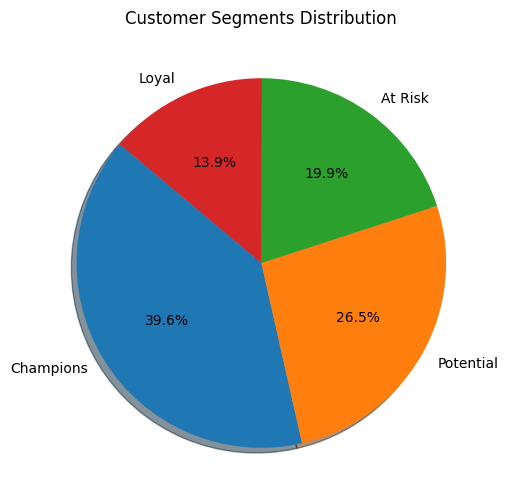

In [28]:
import matplotlib.pyplot as plt

# Segment counts
segment_counts = rfm['Segment'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True
)
plt.title("Customer Segments Distribution")
plt.show()


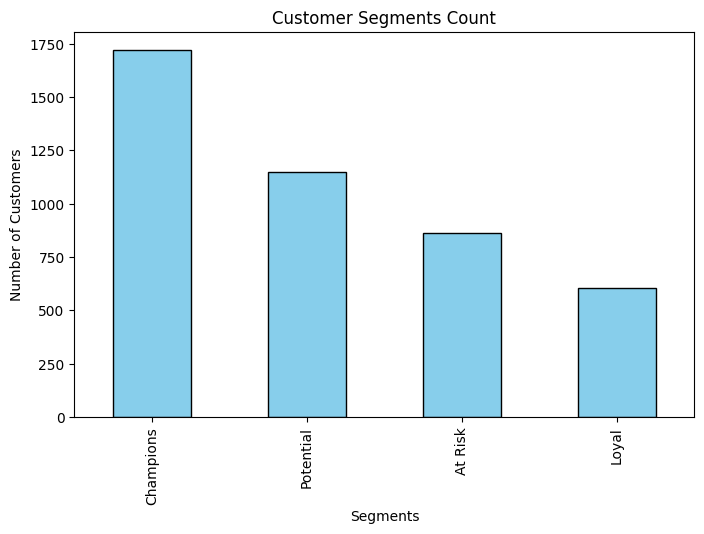

In [29]:
plt.figure(figsize=(8,5))
segment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Customer Segments Count")
plt.xlabel("Segments")
plt.ylabel("Number of Customers")
plt.show()


# **Customer Segment Insights**

Champions 🏆

These are the best customers.

They buy frequently, recently, and spend the most.

Action: Keep them happy with loyalty programs and special offers.

Loyal Customers 🤝

They purchase regularly but may not always spend the highest.

Action: Provide exclusive discounts or memberships to retain them.

Potential Loyalists 🌱

Recently started buying and show good frequency.

Action: Convert them into loyal customers by engaging campaigns.

At Risk ⚠️

Used to be good customers but haven’t bought recently.

Action: Re-engage with targeted promotions or reminders.

Hibernating 💤

Very old customers with low frequency and spending.

Action: Can be reactivated with big discounts or new product launches.

Others

Customers who don’t fit clearly into the above categories.

Action: Monitor and decide strategy case by case.
